In [49]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

In [50]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
# 가족수 컬럼 추가
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] +1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] +1 
# Fare(요금) log 함수 취하기
df_train['Fare']= df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare']= df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

# 3. Feature engineering 
- dataset에 존재하는 null data 처리, train, test 데이터 모두 적용

## 3.1 Fill Null
### 3.1.1 Fill Null in Age using title
- Age에는 null data가 177개가 존재함. 이를 해결하기 위해 title과 statistics를 사용
- 영어권에서 title은 Mis, Mrr, Mrs 와 같은 title이 존재. 
- pandas series에 str method, extract method 활용하여 Initial Column 생성

In [52]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') ## 직함, 성 추출
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.') ## 직함, 성 추출

In [53]:
df_train['Initial'] 

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object

- pandas의 crosstab을 이용해 추출한 Initial과 Sex간의 count를 살펴보자

In [54]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 테이블을 참고 하여 남자, 여자가 쓰는 Initial을 구분
- replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환한다.

In [55]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [56]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관련있는 Miss, Mr, Mrs가 생존률이 높은 것으로 확인되었다.

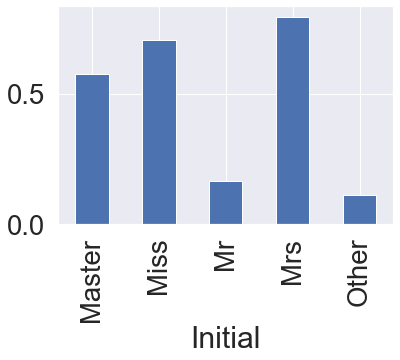

In [57]:
 df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [58]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용하여 Null Value를 채운다. 
- pandas dataframe : boolean array를 이용하여 indexing 한다.

In [59]:
# loc + boolean + column 을 사용하여 값을 치환 
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [60]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null Values')

Embarked has  2 Null Values


- Embarked 변수에 Null 값은 2개 존재한다. 
- dataframe의 fillna method를 이용하여 가장 많은 탑승객이었던 S를 채워준다. 

In [61]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)
- Age는 연속 변수. 몇개의 group으로 나누어 category화 시켜준다.
- categorial을 진행하면 information loss가 생길 수도 있음을 간과해선 안된다.
- 방법 : dataframe의 indexing 방법인 loc 사용, apply 함수 사용

In [62]:
# 나이는 10살 간격으로 나눈다.
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'] , 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'] , 'Age_cat'] = 7

In [63]:
# 두번째 방법 apply 메소드 활용
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [64]:
# 두가지 방법이 같은 결과가 나왔는지 확인해본다. 
# Series 간 boolean 비교 후 all() 메소드 사용. 
print ( '1번 방법, 2번 방법 둘다 같은 결과면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과면 True ->  True


In [65]:
# 위의 두가지 방법이 동일한 것임을 확인하였으므로, 원래 있는 Age 컬럼과 Age_cat2컬럼을 삭제
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (String to Numeric)
- 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어짐. 
- 텍스트 카테고리로 표현된 것을 수치화
- map method 사용
- 사전순서대로 매핑

In [66]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

- C, Q, S로 이루어진 Embarked 변수도 수치화 표현

In [67]:
# 어떤 값들이 있는지 확인
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [68]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [69]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [70]:
# isnull(), null이 하나라도 있으면 True, 없으면 False
df_train['Embarked'].isnull().any()

False

In [71]:
# 성별도 수치화 표현 
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 각 feature 간의 상관관계
- 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있음.
- 1로 갈 수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미. 0은 상관관계가 없다는 것을 의미.
- heatmap plot : 여러 변수의 상관관계를 matrix로 표현
- dataframe의 corr() 메소드와 seaborn으로 표현

In [72]:
df_train['Sex']

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

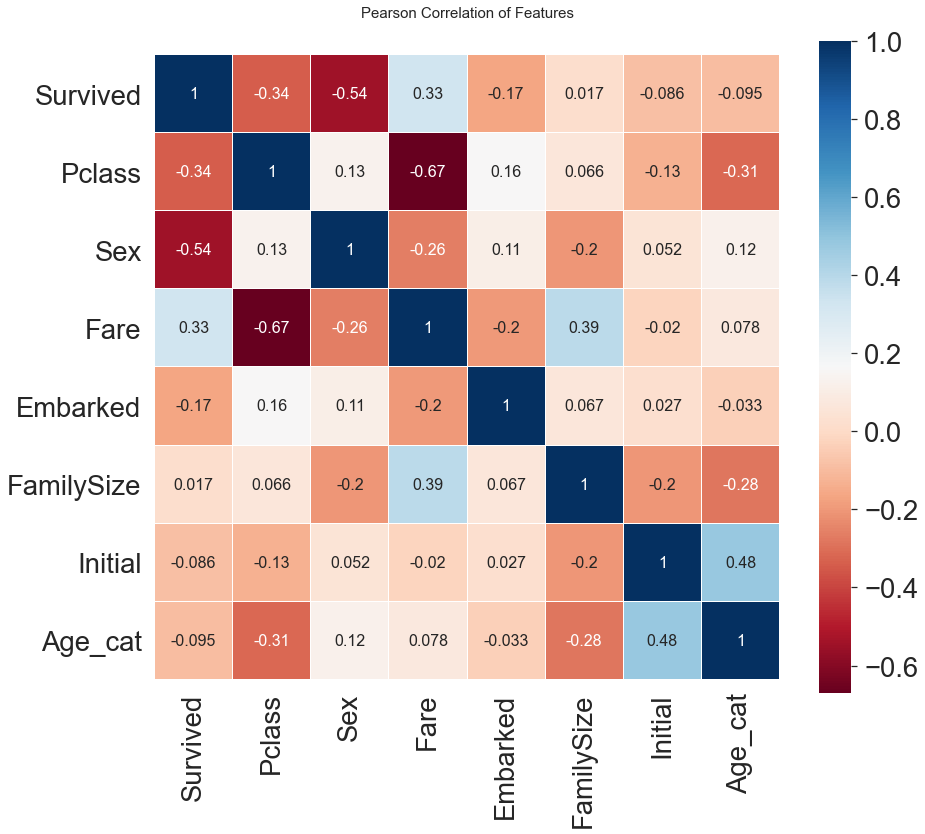

In [75]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- 이전에 EDA에서 살펴봤듯이 Sex, Pclass는 Survived와 어느정도 상관관계가 있다. 
- 하지만 여기서 얻을수 있는 정보는 서로 강한 상관관계를 가지는 feature는 없다는 것이다. 
- 이것은 모델을 학습시킬 때, 불필요한 (redundant, superfluous) feature가 없다는 것을 의미한다. 

## 3.4 One-hot encoding on Initial and Embarked
- 모델 학습하기 이전에 데이터 전처리 (data preprocessing)을 진행한다. 
- 수치화 시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해준다. 
    - 수치화는 간단히 Master=0, Miss=1, Mr=2, Mrs=3, Other=4로 매핑해주는 것을 의미한다. 
- One-Hot encoding은 위 카테고리를 아래와 같이 (0,1) 로 이루어진 5차원 벡터로 나타내는 것을 의미한다. 
- pandas의 get_dummies를 사용하면 쉽게 해결 가능하다.
- 카테고리 갯수만큼 새로운 컬럼이 생긴다.

In [77]:
# Initial을 prefix로 두어서 구분을 쉽게 할수 있도록 한다. 
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [79]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [80]:
# Embarked도 적용
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [81]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,1,3,0,0,1,0,0,0,0,1


- 이 방법외에 sklearn로 Labelencoder + OneHotencoder를 이용해도 된다. 

## 3.5 Drop columns

In [82]:
# 필요한 컬럼만 남기고 삭제
df_train.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

In [83]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [86]:
df_test.head()
# train의 Survived feature(target class)만 제외하면 나머지 컬럼은 동일하다.

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 4. Building machine learning model and prediction using the trained model

In [91]:
# 머신러닝 준비
from sklearn.ensemble import RandomForestClassifier # 랜던포레스트 
from sklearn import metrics # 모델 평가를 위해
from sklearn.model_selection import train_test_split # training set 분리 

- 타이타닉 문제는 target class(survived)가 있으며, target class는 0,1이루어져 있으므로 binary classification 문제이다.
- train set의 survived를 제외한 input을 가지고 모델을 최적화 시켜 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 생성한다. 
- 그 후 모델이 학습하지 않았더 test set을 input으로 주어 test set의 각 샘플(탑승객)의 생존 유무를 예측한다. 

## 4.1 Preparation - Split dataset into train, valid, test set
- 가장 먼저, 학습에 쓰일 데이터와 target label(Survived)를 분리한다. 

In [92]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values 
X_test = df_test.values

In [94]:
# 실제 test set에 적용하기 전에 valid set을 생성하여 모델을 적용해본다.
# train_test_split을 사용하여 train 셋을 분리할 수 있다.
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- 랜덤포레스트는 결정트리(Decision Tree)를 기반으로 한다. 
- 랜덤포레스트 파라미터 : n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등..

## 4. 2 Model generation and prediction

In [96]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [97]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


## 4.3 Feature importance
- 학습된 모델은 feature importance를 갖게 된다.
- pandas series를 이용하면 쉽게 sorting을 하여 그래프를 그릴 수 있다. 

In [101]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

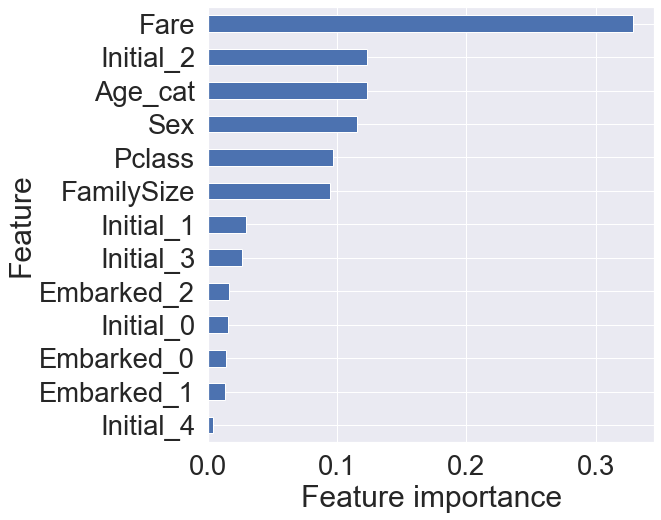

In [102]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare가 가장 큰 영향렬을 가진다. 그뒤로 Inital_2, Age_cat, Set, Pclass 순으로 중요도를 가진다.
- 위의 feature importance는 지금 이 모델에서만 해당한다. 다른 모델에서는 결과가 다르게 나올 수 있다. 
- 그러므로 통계적으로 좀더 살펴보아야한다. 
- feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 featrue selection을 할 수도 있고, 좀 더 빠른 모델을 위해 feature을 제거할 수도 있다. 

## 4.4 Prediction on Test Set
- 이제 모델이 학습하지 않았던 테스트셋을 모델에 주어서 생존 여부를 예측해보자. 
- 이 결과는 실제로 submission(제출용)이므로 결과는 learnboard 에서 확인할 수 있다. 

In [103]:
## 캐글에서 준 파일인 gender_submission.csv 파일을 읽어 제출 준비를 한다.
submission = pd.read_csv('../data/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [105]:
# test set에 대하여 예측하고 결과를 scv 파일로 저장한다. 
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [106]:
submission.to_csv('../data/my_fist_submission.csv', index = False)